In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
# add local forder to python lib ## why it's not working here but works in command line?
import importlib
from sc_utils import scanpy_utils as su
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from matplotlib.pyplot import rc_context
import numpy as np
import scipy.sparse as sp
import anndata
from typing import Dict, Optional
from collections import defaultdict
import itertools
import pygame
from matplotlib import cm
import matplotlib
import seaborn as sns
from collections import Counter

pygame 2.1.3.dev8 (SDL 2.26.3, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_theme(style="ticks", rc=custom_params)
matplotlib.rcParams['figure.figsize'] = [6, 5]


In [3]:
## check versions
## testing stage, with high verbosity
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=900, color_map = 'viridis_r')

2024-05-11 14:56:24.197340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


scanpy==1.10.0 anndata==0.8.0 umap==0.5.5 numpy==1.26.3 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.4.0 statsmodels==0.14.0 igraph==0.10.3 pynndescent==0.5.8


In [4]:
os.chdir('/mnt/data/hong/2022/human_placenta/')

In [5]:
ad_clean = sc.read_h5ad('output/10x_h5/h5ad/ad_v2.h5ad')

In [8]:
ad_clean.X = ad_clean.layers['log_norm']
ad_clean.write_h5ad('output/10x_h5/h5ad/ad_v2_cellgene.h5ad')

In [5]:
ad_clean = sc.read_h5ad('output/10x_h5/h5ad/ad_v1.0.h5ad')
stb = sc.read_h5ad('output/10x_h5/h5ad/stb_v8.h5ad')

In [6]:
left = ad_clean.obs
stb_states = stb.obs['maturation_inhouse_three']

In [14]:
# # ## left join to keep all cells
# left = left.join(stb_states, how='left')
# # ## where 'maturation_inhouse_three' is nan, take the column from subset column from the same row
# ## category to string
# left['subset'] = left['subset'].astype(str)
# left['maturation_inhouse_three'] = left['maturation_inhouse_three'].astype(str)
# left['final_celltypes'] = left['maturation_inhouse_three'].fillna(left['subset'])
left['final_celltypes'] = np.where(left['maturation_inhouse_three']=='nan', left['subset'], left['maturation_inhouse_three'])

In [15]:
left['final_celltypes'].value_counts()

STB-c             16087
STB-b              6646
CTB                3593
Endo-1             2197
Fibroblast         1937
STB-a              1847
Hofbauer cells     1749
pCTB                768
Myofibroblast       758
NK cells            406
Endo-2              393
eSTB                320
Monocyte            265
EVT                 205
T cells             137
B cells             100
Name: final_celltypes, dtype: int64

In [16]:
ad_clean.obs = left

In [12]:
ad_clean

AnnData object with n_obs × n_vars = 37408 × 26913
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'sample', 'group', 'batch', 'sex', 'mother', 'Hemoglobins', 'S_score', 'G2M_score', 'phase', 'leiden', 'cell type', 'subset', 'C_scANVI', 'maturation_inhouse_three', 'final_celltypes'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'group_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'pearson_residuals_normalization', 'subset_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'latent_gene_encoding'
    varm: 'PCs'
    layers: 'log_norm', 'raw', 'sqrtCPMedian', 'sqrt_norm'
    obsp: 'connectivities', 'distances'

In [17]:
## write out
ad_clean.write('output/10x_h5/h5ad/ad_v2.h5ad')

In [6]:
# ad_all = sc.read_h5ad('output/10x_h5/h5ad/ad_v0.9.h5ad')
scvi = sc.read_h5ad('output/10x_h5/h5ad/with_ng/NatGenet_Hong_scANVI.h5ad')

In [5]:
adata = sc.read_h5ad('output/10x_h5/h5ad/ad_v1.0.h5ad')
sct = adata[adata.obs.subset=='STB']

In [11]:
sct_mainfig = sc.read_h5ad('output/10x_h5/h5ad/stb_v8.h5ad')

In [7]:
scvi_hong = scvi[scvi.obs['orig.ident']=='SeuratProject']

In [8]:
scvi_hong.obs_names = scvi_hong.obs_names.str.strip('-HongProj')

/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:873: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_index(names, "obs")


In [9]:
scvi_hong.obs['STB_subtype'] = 'mature STB'
scvi_hong.obs['STB_subtype'].where(scvi_hong.obs['C_scANVI'].str.startswith('mature'), 'immature STB', inplace=True)

In [10]:
ad_all.obs = ad_all.obs.join(scvi_hong.obs['C_scANVI'], how='left')

In [11]:
## write out ad_all
ad_all.write('output/10x_h5/h5ad/ad_v1.0.h5ad', compression='gzip')

In [12]:
pd.crosstab(scvi_hong.obs['STB_subtype'],scvi_hong.obs['group'], normalize='columns')

group         Normal_AGA  Obese_AGA  Obese_LGA
STB_subtype                                   
immature STB    0.590479   0.485096   0.527778
mature STB      0.409521   0.514904   0.472222

In [39]:
pd.crosstab(scvi_hong.obs['C_scANVI'],scvi_hong.obs['group'], normalize='columns')

group         Normal_AGA  Obese_AGA  Obese_LGA
C_scANVI                                      
mature1-a       0.089796   0.087261   0.097209
mature1-b       0.135363   0.157888   0.126220
mature1-c       0.076219   0.115908   0.094321
mature2-a       0.172598   0.182970   0.168569
mature2-b       0.038675   0.046997   0.045923
nascent         0.094734   0.108515   0.135707
premature1-a    0.219708   0.147591   0.193455
premature1-b    0.172907   0.152871   0.138595

In [40]:
pd.crosstab(scvi_hong.obs['C_scANVI'],scvi_hong.obs['group'])

group         Normal_AGA  Obese_AGA  Obese_LGA
C_scANVI                                      
mature1-a            873        661        707
mature1-b           1316       1196        918
mature1-c            741        878        686
mature2-a           1678       1386       1226
mature2-b            376        356        334
nascent              921        822        987
premature1-a        2136       1118       1407
premature1-b        1681       1158       1008

In [42]:
pd.crosstab(ad_all.obs['subset'],ad_all.obs['group'], normalize='columns')

group           Normal_AGA  Obese_AGA  Obese_LGA
subset                                          
B cells           0.001194   0.006258   0.000635
CTB               0.090462   0.092062   0.107655
EVT               0.006040   0.003706   0.006711
Endo-1            0.056328   0.075840   0.042989
Endo-2            0.011448   0.011281   0.008435
Fibroblast        0.059559   0.046607   0.047433
Hofbauer cells    0.035328   0.050478   0.057410
Monocyte          0.003371   0.012928   0.005442
Myofibroblast     0.020157   0.023880   0.016416
NK cells          0.005759   0.018692   0.008797
STB               0.683102   0.624341   0.659532
T cells           0.000843   0.008399   0.002086
eSTB              0.008498   0.007905   0.009342
pCTB              0.017910   0.017622   0.027118

In [6]:
## add sct time to the cel barcode information
sct_time = pd.read_csv('output/trajectory/sct_time_df.tsv', sep='\t')

In [7]:
sct_mainfig.obs = pd.merge(sct_mainfig.obs, sct_time, left_index=True, right_index=True)

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


df = sct.obs[['C_scANVI', 'Group', 'Pseudotime_sct']]
# df_naga = df[df['Group']=='N_AGA']
# Initialize the FacetGrid object
color_dict = {'Normal_AGA' : np.array(pygame.Color('#74b3ce'))/255,
'Obese_AGA' : np.array(pygame.Color('#f7b801'))/255, 
'Obese_LAGA' : np.array(pygame.Color('#f7717d'))/255}
g = sns.FacetGrid(df, row="C_scANVI", hue="Group", aspect=15, height=.5, palette=[np.array(pygame.Color('#f7b801'))/255, np.array(pygame.Color('#f7717d'))/255, np.array(pygame.Color('#74b3ce'))/255], row_order=['nascent', 'premature1-a', 'premature1-b', 'mature1-a', 'mature1-b', 'mature1-c', 'mature2-a', 'mature2-b'])

# Draw the densities in a few steps
g.map(sns.kdeplot, "Pseudotime_sct",
      bw_adjust=.5, clip_on=False,
      fill=False, alpha=0.1, linewidth=1.5)
g.map(sns.kdeplot, "Pseudotime_sct", clip_on=False, color=None, lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color='black', clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Pseudotime_sct")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
## save plot
g.savefig('figures/trajectory/scANVI_pseudotime_onlysct.pdf')

/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decoration

In [8]:
sct_mainfig

AnnData object with n_obs × n_vars = 24580 × 26913
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'sample', 'group', 'batch', 'sex', 'mother', 'Hemoglobins', 'S_score', 'G2M_score', 'phase', 'leiden', 'cell type', 'subset', 'C_scANVI', 'maturation', 'maturation_my', 'maturation_inhouse', 'Pseudotime_sct_x', 'Group_x', 'maturation_inhouse_three', 'maturation_inhouse_v8', 'Pseudotime_sct_y', 'Group_y'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'C_scANVI_colors', 'group_colors', 'hvg', 'leiden', 'leiden_colors', 'maturation_colors', 'maturation_inhouse_colors', 'maturation_inhouse_v8_colors', 'maturation_my_colors', 'neighbors', 'pca', 'pearson_residuals_normalization', 'subset_colors', 'umap'
    obsm: 'X_pca

/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decoration

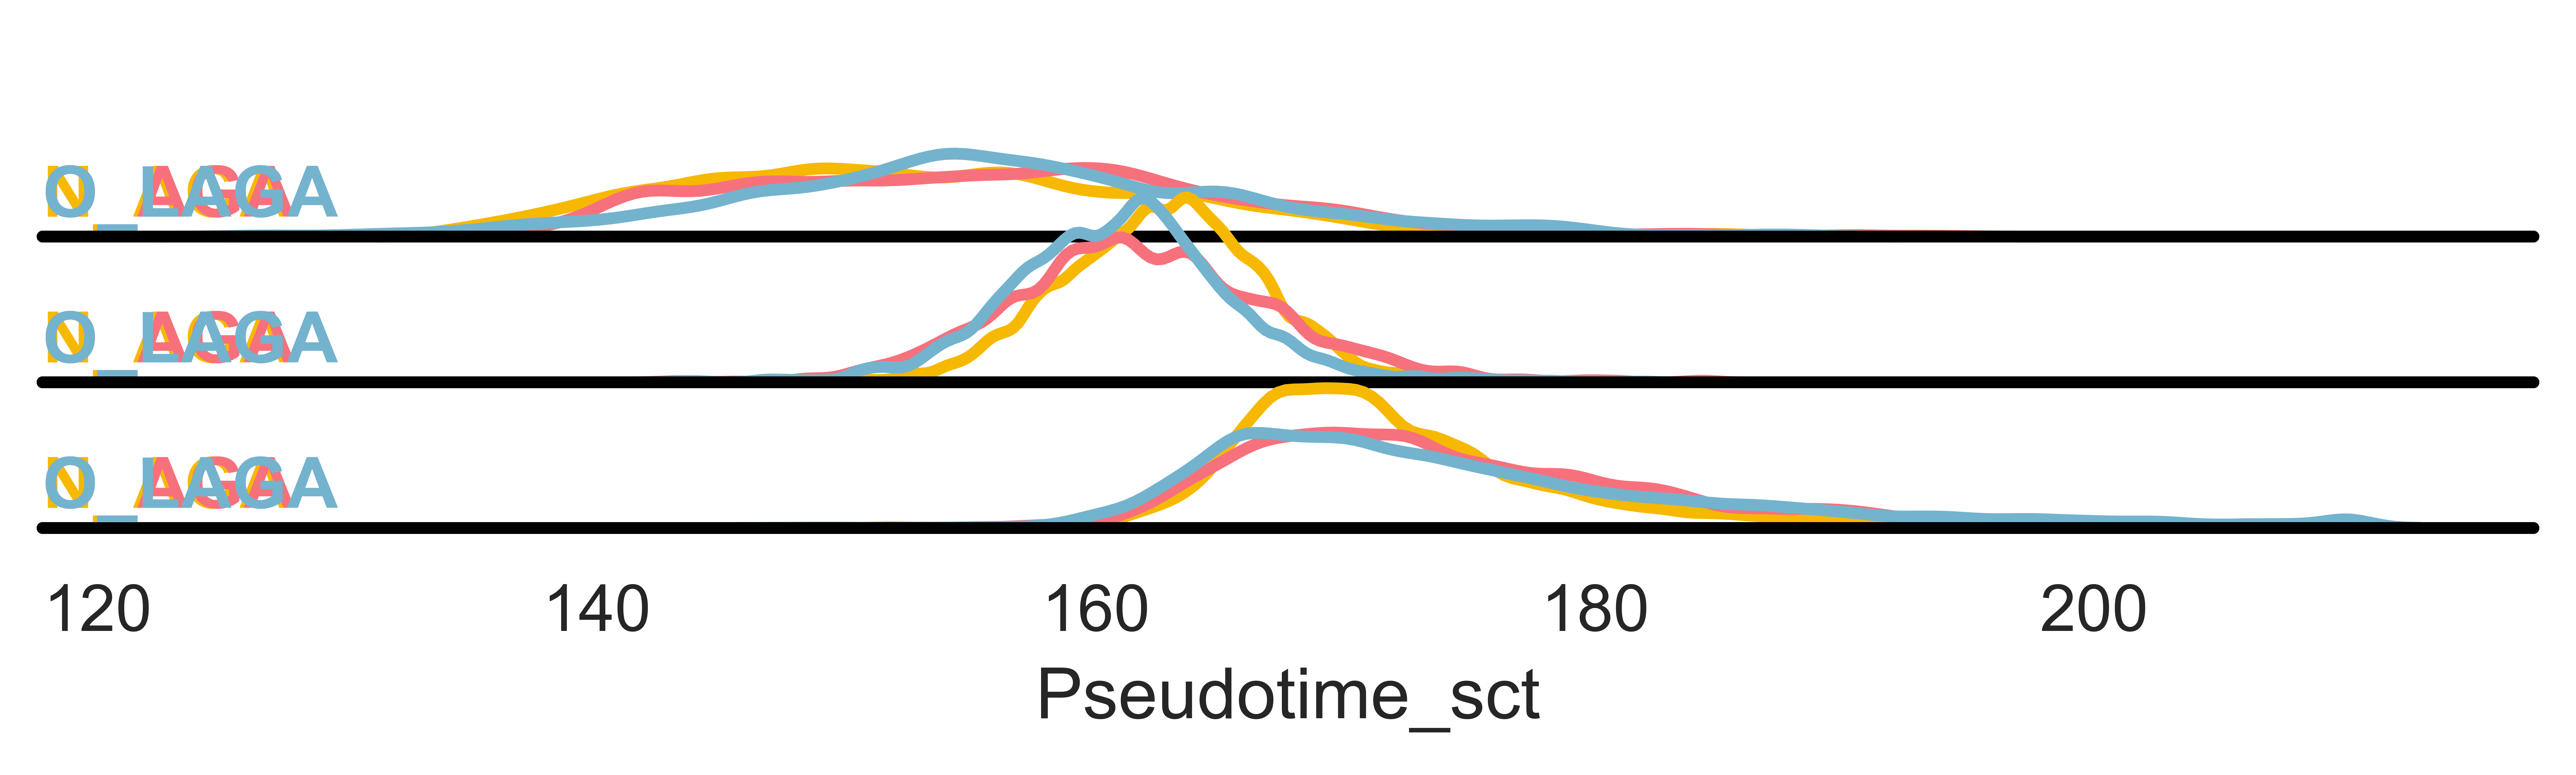

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


df = sct_mainfig.obs[['maturation_inhouse_three', 'Group', 'Pseudotime_sct']]
# df_naga = df[df['Group']=='N_AGA']
# Initialize the FacetGrid object
color_dict = {'Normal_AGA' : np.array(pygame.Color('#74b3ce'))/255,
'Obese_AGA' : np.array(pygame.Color('#f7b801'))/255, 
'Obese_LAGA' : np.array(pygame.Color('#f7717d'))/255}
g = sns.FacetGrid(df, row="maturation_inhouse_three", hue="Group", aspect=15, height=.5, palette=[np.array(pygame.Color('#f7b801'))/255, np.array(pygame.Color('#f7717d'))/255, np.array(pygame.Color('#74b3ce'))/255], row_order=['STB-a', 'STB-b', 'STB-c'])

# Draw the densities in a few steps
g.map(sns.kdeplot, "Pseudotime_sct",
      bw_adjust=.5, clip_on=False,
      fill=False, alpha=0.1, linewidth=1.5)
g.map(sns.kdeplot, "Pseudotime_sct", clip_on=False, color=None, lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color='black', clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Pseudotime_sct")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
## save plot
g.savefig('figures/trajectory/scANVI_pseudotime_onlysct_v8_three.pdf')

In [14]:
## count the category and plot the barplot
pd.crosstab(sct_mainfig.obs['maturation_inhouse_three'], sct_mainfig.obs['sample'], normalize='columns')

sample                    placenta_25  placenta_32  placenta_60  placenta_81  \
maturation_inhouse_three                                                       
STB-a                        0.080242     0.142857     0.095428     0.043419   
STB-b                        0.174111     0.261048     0.334928     0.178765   
STB-c                        0.745647     0.596095     0.569644     0.777815   

sample                    placenta_248  placenta_303  placenta_306  \
maturation_inhouse_three                                             
STB-a                         0.088639      0.039946      0.149730   
STB-b                         0.350187      0.131686      0.141384   
STB-c                         0.561174      0.828368      0.708886   

sample                    placenta_312  placenta_314  placenta_330  \
maturation_inhouse_three                                             
STB-a                         0.066901      0.102041      0.059674   
STB-b                         0.595070      0.377551      0.415851   
STB-c                         0.338028      0.520408      0.524476   

sample                    placenta_357  placenta_373  
maturation_inhouse_three                              
STB-a                         0.049448      0.085591  
STB-b                         0.309169      0.231527  
STB-c                         0.641383      0.682882

In [16]:
pd.crosstab(sct_mainfig.obs['sample'], sct_mainfig.obs['maturation_inhouse_three'])

maturation_inhouse_three  STB-a  STB-b  STB-c
sample                                       
placenta_25                 106    230    985
placenta_32                 139    254    580
placenta_60                 359   1260   2143
placenta_81                 128    527   2293
placenta_248                142    561    899
placenta_303                118    389   2447
placenta_306                305    288   1444
placenta_312                 57    507    288
placenta_314                 20     74    102
placenta_330                128    892   1125
placenta_357                206   1288   2672
placenta_373                139    376   1109

In [73]:
df_naga = df[df['Group']=='O_AGA']
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(8, rot=-.25, light=.7)
g = sns.FacetGrid(df_naga, row="C_scANVI", hue="C_scANVI", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Pseudotime_sct",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Pseudotime_sct", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Pseudotime_sct")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
## save plot
g.savefig('figures/trajectory/scANVI_pseudotime_OAGA.pdf')

/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decoration

In [75]:
df_naga = df[df['Group']=='O_LAGA']
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(8, rot=-.25, light=.7)
g = sns.FacetGrid(df_naga, row="C_scANVI", hue="C_scANVI", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Pseudotime_sct",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Pseudotime_sct", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Pseudotime_sct")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
## save plot
g.savefig('figures/trajectory/scANVI_pseudotime_OLAGA.pdf')

/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decoration

In [81]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(8, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="C_scANVI", hue="C_scANVI", aspect=15, height=.5, palette=pal, row_order=['nascent', 'premature1-a', 'premature1-b', 'mature1-a', 'mature1-b', 'mature1-c', 'mature2-a', 'mature2-b'])

# Draw the densities in a few steps
g.map(sns.kdeplot, "Pseudotime_sct",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Pseudotime_sct", clip_on=False, color="w", lw=2, bw_adjust=.5)
# g.set(xlim=(150, 200))
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Pseudotime_sct")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
## save plot
g.savefig('figures/trajectory/scANVI_pseudotime_all.pdf')

/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/data/hong/anaconda3/envs/scanpy/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decoration